# Fit ZP Lee's spectra

In [57]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from ocpy.hydrolight import loisel23
from ocpy.utils import plotting as oc_plotting
from ocpy.satellites import pace as sat_pace
from ocpy.water import absorption

from ocpy.satellites import modis as sat_modis
from ocpy.satellites import pace as sat_pace
from ocpy.satellites import seawifs as sat_seawifs

from bing.models import anw as boring_anw
from bing.models import bbnw as boring_bbnw
from bing.models import utils as model_utils
from bing.models import functions
from bing import inference as big_inf
from bing import rt as bing_rt
from bing import chisq_fit
from bing import plotting as bing_plot


In [2]:
%matplotlib ipympl

# Load

## Load up Loisel+2023 Hydrolight dataset

## Using the full run (inelastic scattering) at Zenith

In [3]:
ds = loisel23.load_ds(4,0)

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
all_a = ds.a.data
all_bb = ds.bb.data
all_bbnw = ds.bbnw.data
all_adg = ds.ag.data + ds.ad.data
all_ad = ds.ad.data
all_ag = ds.ag.data
all_aph = ds.aph.data
all_anw = ds.anw.data

In [5]:
aw = all_a[0] - all_anw[0]

In [6]:
all_anw.shape

(3320, 81)

### $b_{\rm b,w}$

In [30]:
l23_bbw = all_bb[0] - all_bbnw[0]

## Lee $a_{\rm ph}$

In [7]:
lee_file = 'ZP_Lee/aph_samples.csv'
df_lee = pandas.read_csv(lee_file)
df_lee.head()

,wave,aph_1,aph_2
0,400,0.383277,0.118626
1,405,0.394072,0.122840
2,410,0.428293,0.132003
3,415,0.450018,0.136293
4,420,0.458255,0.137845


## Plot em

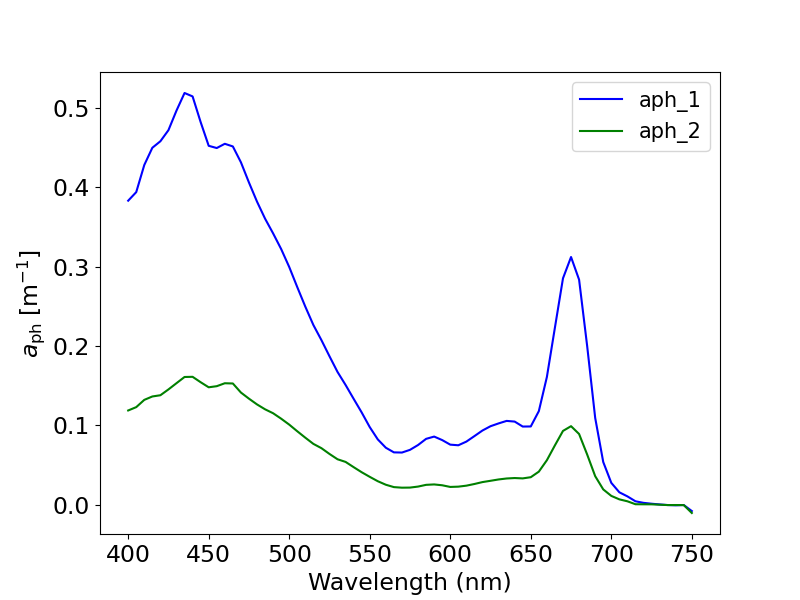

In [8]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.plot(df_lee.wave, df_lee.aph_1, 'b-', label='aph_1')
ax.plot(df_lee.wave, df_lee.aph_2, 'g-', label='aph_2')
#
ax.set_xlabel(r'Wavelength (nm)')
ax.set_ylabel(r'$a_{\rm ph} \; [\rm m^{-1}]$')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## Whoa, those are pretty extreme!

# Setup

In [9]:
i440 = np.argmin(np.abs(l23_wave-440.))
i600 = np.argmin(np.abs(l23_wave-600.))

# $b_{\rm b,nw}$ histogram at 600nm

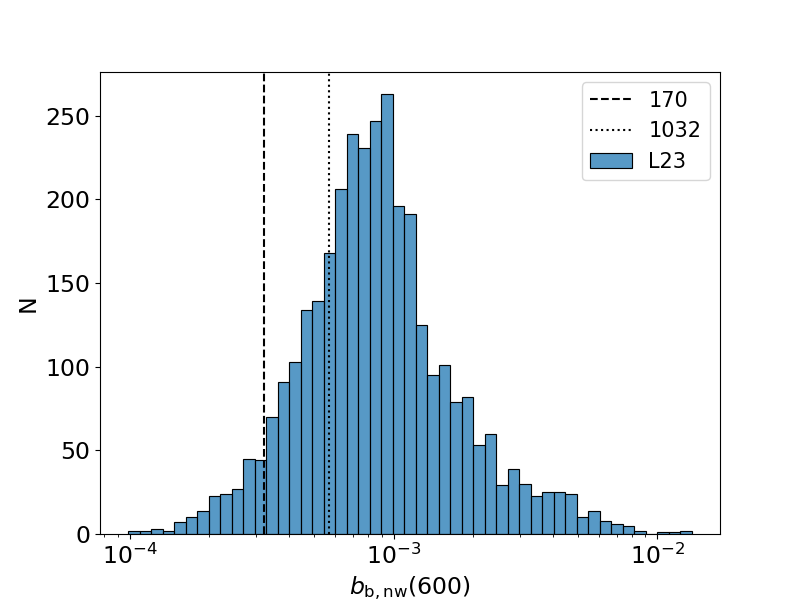

In [10]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

sns.histplot(all_bbnw[:,i600], log_scale=(True,False), label='L23')
#
ax.set_xlabel(r'$b_{\rm b,nw}(600)$')
ax.set_ylabel('N')
# Mark the two in the paper
ax.axvline(all_bbnw[170,i600], color='k', ls='--', label='170')
ax.axvline(all_bbnw[1032,i600], color='k', ls=':', label='1032')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## So our two examples in the BING paper are below the median but not woefully so

# Let's grab fake $a_{dg}$ and $b_{b,nw}$

## Large values for each

In [11]:
i_bb = np.argmin(np.abs(all_bbnw[:,i600]-0.01))
i_bb

2343

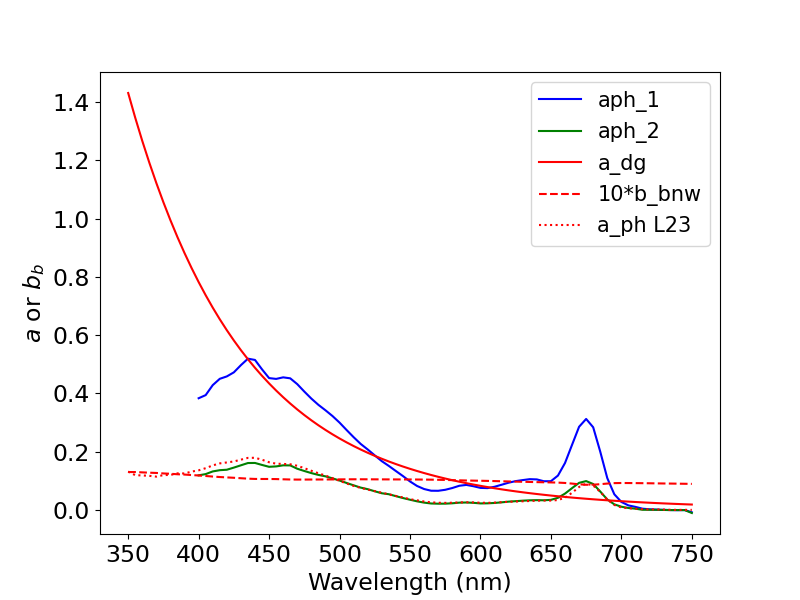

In [24]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.plot(df_lee.wave, df_lee.aph_1, 'b-', label='aph_1')
ax.plot(df_lee.wave, df_lee.aph_2, 'g-', label='aph_2')
# 
ax.plot(l23_wave, all_adg[i_bb], 'r-', label='a_dg')
ax.plot(l23_wave, 10*all_bbnw[i_bb], 'r--', label='10*b_bnw')
ax.plot(l23_wave, all_aph[i_bb], 'r:', label='a_ph L23')
#
ax.set_xlabel(r'Wavelength (nm)')
ax.set_ylabel(r'$a$ or $b_b$')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## Maybe we should scale up for aph_1

# Prep

## Generate total $a$ and $b_b$

### $a_{\rm dg}$

In [22]:
f_dg = interp1d(l23_wave, all_adg[i_bb])
lee_adg = f_dg(df_lee.wave)
lee_adg[0:5]

array([0.78220999, 0.73695999, 0.69444001, 0.65447003, 0.61691999])

### $a_w$

In [29]:
lee_aw = absorption.a_water(df_lee.wave)

## $b_{b,nw}$

In [23]:
f_bb = interp1d(l23_wave, all_bbnw[i_bb])

### $b_{b,w}$

In [31]:
f_bbw = interp1d(l23_wave, l23_bbw)
lee_bbw = f_bbw(df_lee.wave)

### Add em up

In [52]:
a_1 = lee_adg + df_lee.aph_1 + lee_aw
a_2 = lee_adg + df_lee.aph_2 + lee_aw
#
bb_2 = f_bb(df_lee.wave) + lee_bbw
bb_1 = bb_2 * 2 + lee_bbw
# For initial guess
anw_1 = a_1 - lee_aw
anw_2 = a_2 - lee_aw
bbnw_1 = bb_1 - lee_bbw
bbnw_2 = bb_2 - lee_bbw

## $R_{\rm rs}$

In [40]:
gordon_Rrs_1 = bing_rt.calc_Rrs(a_1, bb_1)
gordon_Rrs_2 = bing_rt.calc_Rrs(a_2, bb_2)

## Generate satellite spectra

In [42]:
f_sat_1 = interp1d(df_lee.wave, gordon_Rrs_1, kind='linear', fill_value='extrapolate')
f_sat_2 = interp1d(df_lee.wave, gordon_Rrs_2, kind='linear', fill_value='extrapolate')

### MODIS first

In [43]:
modis_Rrs_1 = f_sat_1(sat_modis.modis_wave)
modis_Rrs_2 = f_sat_2(sat_modis.modis_wave)

In [44]:
err_dict = sat_modis.calc_errors(reduce_by_in_situ=0.5)
modis_varRrs = np.array([err_dict[wv][0] for wv in sat_modis.modis_wave])**2

### PACE

In [46]:
PACE_wave = np.arange(400, 701, 5)
pace_Rrs_1 = f_sat_1(PACE_wave)
pace_Rrs_2 = f_sat_2(PACE_wave)

In [48]:
PACE_error = sat_pace.gen_noise_vector(PACE_wave)  
PACE_varRrs = PACE_error**2

# Models

## $k=2$

In [50]:
model_names_2 = ['Cst', 'Cst']
modis_models_2 = model_utils.init(model_names_2, modis_wave)

## $k=3$

In [69]:
model_names_3 = ['Exp', 'Cst']
modis_models_3 = model_utils.init(model_names_3, modis_wave)

### Initial guess

In [51]:
def init_guess(models, anw, bbnw):
    p0_a = models[0].init_guess(anw)
    p0_b = models[1].init_guess(bbnw)
    p0 = np.concatenate((np.log10(np.atleast_1d(p0_a)), 
                         np.log10(np.atleast_1d(p0_b))))
    return p0

# Fit

In [95]:
def grab_items(aidx:int, satellite:str):
    if aidx == 1:
        anw, bbnw = anw_1, bbnw_1
        Rrs = modis_Rrs_1 if satellite == 'MODIS' else pace_Rrs_1
    elif aidx == 2:
        anw, bbnw = anw_2, bbnw_2
        Rrs = modis_Rrs_2 if satellite == 'MODIS' else pace_Rrs_2
        
    if satellite == 'MODIS':
        varRrs = modis_varRrs
        
    return anw, bbnw, Rrs, varRrs

In [97]:
def fit_one(models, aidx, satellite): #Rrs, varRrs, anw, bbnw):

    # Grab
    anw, bbnw, Rrs, varRrs = grab_items(aidx, satellite)
        
    p0 = init_guess(models, anw, bbnw)
    items = [(Rrs, varRrs, p0, None)]
    ans, cov, _ = chisq_fit.fit(items[0], models)
    # 
    print('ans', ans)
    #
    return ans, cov

In [106]:
def plot_one(models, ans, aidx, satellite:str):
    anw, bbnw, Rrs, varRrs = grab_items(aidx, satellite)
    bing_plot.show_fit(models, ans, None, None,
                   figsize=(9,4),
                   Rrs_true=dict(wave=models[0].wave, spec=Rrs, var=varRrs),
                   #Rrs_true=dict(wave=df_lee.wave, spec=gordon_Rrs_1),
                   anw_true=dict(wave=df_lee.wave, spec=anw),
                   bbnw_true=dict(wave=df_lee.wave, spec=bbnw),
                   )

<module 'bing.plotting' from '/home/xavier/Projects/Oceanography/python/bing/bing/plotting.py'>

## $k=2$

### MODIS

In [84]:
ans_modis_21, cov_modis_21 = fit_one(modis_models_2, 1, 'MODIS')

#### Plot

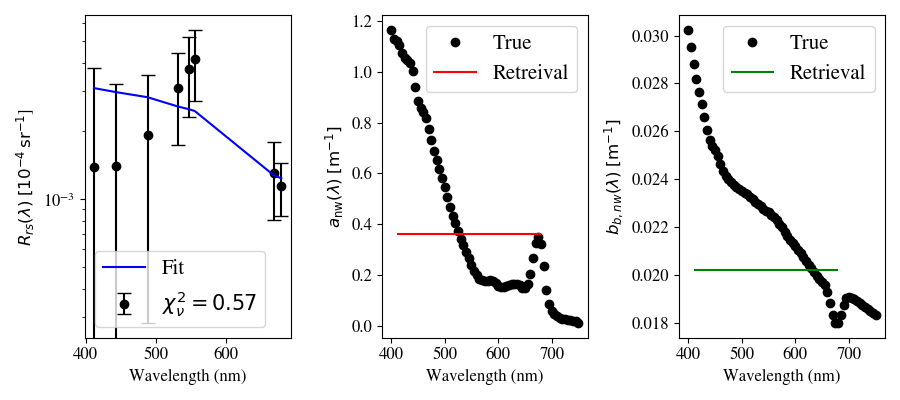

In [109]:
reload(bing_plot)
plot_one(modis_models_2, ans_21, 1, 'MODIS')

## $k=3$

## MODIS

In [92]:
ans_modis_31, cov_modis_31 = fit_one(modis_models_3, 1, 'MODIS')

ans [ 0.03766382 -1.79161442 -1.9638134 ]


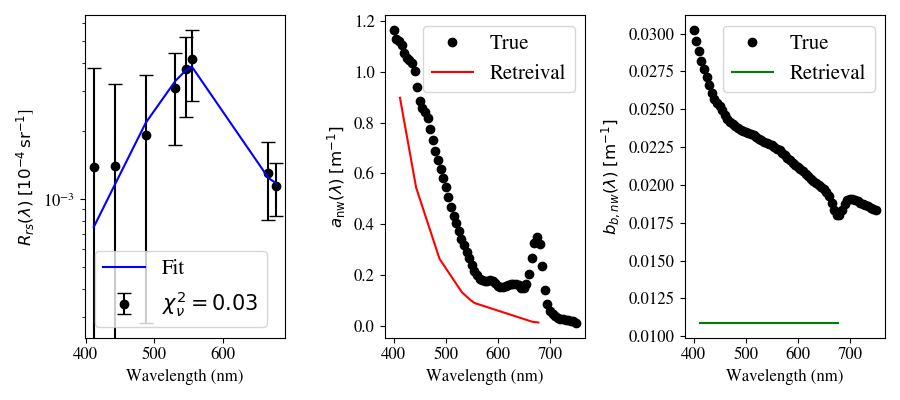

In [110]:
plot_one(modis_models_3, ans_modis_31, 1, 'MODIS')